In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset

# Load datasets
train_df = pd.read_csv('/kaggle/input/med-con/medical_tc_train.csv')
test_df = pd.read_csv('/kaggle/input/med-con/medical_tc_test.csv')
labels_df = pd.read_csv('/kaggle/input/med-con/medical_tc_labels.csv')

# Check dataset balance
print("Training set class distribution:", train_df['condition_label'].value_counts())
print("Test set class distribution:", test_df['condition_label'].value_counts())


In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback, BertConfig, logging as transformers_logging, TrainerCallback
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
from datasets import Dataset, disable_progress_bar

# Disable progress bars
disable_progress_bar()

# Set up logging
transformers_logging.set_verbosity_info()

print("Loading datasets...")
# Load datasets
train_df = pd.read_csv('/kaggle/input/med-con/medical_tc_train.csv')
test_df = pd.read_csv('/kaggle/input/med-con/medical_tc_test.csv')
labels_df = pd.read_csv('/kaggle/input/med-con/medical_tc_labels.csv')

print("Creating label mappings...")
# Create a mapping for label names
label_mapping = dict(zip(labels_df['condition_label'], labels_df['condition_name']))
label_names = labels_df['condition_name'].tolist()

# Ensure labels are zero-indexed
label_mapping_zero_indexed = {label: idx for idx, label in enumerate(labels_df['condition_label'].unique())}
train_df['condition_label'] = train_df['condition_label'].map(label_mapping_zero_indexed)
test_df['condition_label'] = test_df['condition_label'].map(label_mapping_zero_indexed)

print("Preprocessing the data...")
# Preprocess the data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples["medical_abstract"], padding="max_length", truncation=True)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.rename_column("condition_label", "labels")
test_dataset = test_dataset.rename_column("condition_label", "labels")

train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

print("Applying SMOTE to balance the dataset...")
# Apply SMOTE to balance the dataset
X_train = train_df.drop(columns=["condition_label"])
y_train = train_df["condition_label"]

# Assuming "medical_abstract" is the text column
X_train_tokens = [tokenizer.encode(text, add_special_tokens=True, truncation=True, padding="max_length", max_length=512) for text in X_train["medical_abstract"]]
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train_tokens, y_train)

# Convert resampled data back to DataFrame
resampled_train_df = pd.DataFrame({"medical_abstract": [tokenizer.decode(tokens, skip_special_tokens=True) for tokens in X_resampled], "condition_label": y_resampled})

# Tokenize the resampled data
resampled_train_dataset = Dataset.from_pandas(resampled_train_df)
resampled_train_dataset = resampled_train_dataset.map(tokenize_function, batched=True)
resampled_train_dataset = resampled_train_dataset.rename_column("condition_label", "labels")
resampled_train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

print("Calculating class weights...")
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_resampled), y=y_resampled)
class_weights = torch.tensor(class_weights, dtype=torch.float).to('cuda')

print("Defining metrics and custom loss function...")
# Define metrics
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred, average='weighted')
    precision = precision_score(labels, pred, average='weighted')
    recall = recall_score(labels, pred, average='weighted')
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

# Define a custom loss function to include class weights
def compute_loss(model, inputs, return_outputs=False):
    labels = inputs.get("labels")
    outputs = model(**inputs)
    logits = outputs.get("logits")
    loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
    loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
    return (loss, outputs) if return_outputs else loss

print("Setting up training arguments...")
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Use the updated argument name
    save_strategy="epoch",  # Ensure save strategy matches eval strategy
    logging_dir='./logs',
    logging_steps=10,
    per_device_train_batch_size=8,  # Adjust batch size for efficient training
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_strategy="epoch",  # Log at the end of each epoch
    report_to="none"  # Disable logging to external services like W&B
)

print("Initializing model with dropout...")
# Model initialization with dropout
config = BertConfig.from_pretrained("bert-base-uncased", hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3, num_labels=len(label_names))
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

# Custom callback to log additional metrics
class LogCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if state.is_world_process_zero:
            print(f"Epoch {state.epoch}: {logs}")

print("Initializing Trainer...")
# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=resampled_train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    compute_loss=compute_loss,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3), LogCallback()]  # Early stopping and custom logging
)

print("Starting training...")
# Train model
trainer.train()

print("Evaluating model...")
# Evaluate model
eval_results = trainer.evaluate()
print(eval_results)

print("Predicting on test set...")
# Predict
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

print("Generating confusion matrix and classification report...")
# Confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=label_names))

print("Generating ROC and AUROC curves...")
# ROC and AUROC
y_true_bin = label_binarize(y_true, classes=range(len(label_names)))
y_pred_bin = label_binarize(y_pred, classes=range(len(label_names)))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(len(label_names)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_mapping[i+1]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("Plotting training and validation loss curves...")
# Training and validation loss plot
training_loss = [x['loss'] for x in trainer.state.log_history if 'loss' in x]
validation_loss = [x['eval_loss'] for x in trainer.state.log_history if 'eval_loss' in x]
accuracy = [x['eval_accuracy'] for x in trainer.state.log_history if 'eval_accuracy' in x]

epochs = range(1, len(training_loss) + 1)

plt.figure()
plt.plot(epochs, training_loss, 'bo', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.plot(epochs, accuracy, 'g', label='Validation accuracy')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()


In [ ]:

print("Calculating class weights...")
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_resampled), y=y_resampled)
class_weights = torch.tensor(class_weights, dtype=torch.float).to('cuda')

print("Defining metrics and custom loss function...")
# Define metrics
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(labels, pred)
    f1 = f1_score(labels, pred, average='weighted')
    precision = precision_score(labels, pred, average='weighted')
    recall = recall_score(labels, pred, average='weighted')
    return {"accuracy": accuracy, "f1": f1, "precision": precision, "recall": recall}

# Custom Trainer with weighted loss
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

print("Setting up training arguments...")
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Use the updated argument name
    save_strategy="epoch",  # Ensure save strategy matches eval strategy
    logging_dir='./logs',
    logging_steps=10,
    per_device_train_batch_size=8,  # Adjust batch size for efficient training
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_strategy="epoch",  # Log at the end of each epoch
    report_to="none"  # Disable logging to external services like W&B
)

print("Initializing model with dropout...")
# Model initialization with dropout
config = BertConfig.from_pretrained("bert-base-uncased", hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3, num_labels=len(label_names))
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

# Custom callback to log additional metrics
class LogCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        if state.is_world_process_zero:
            print(f"Epoch {state.epoch}: {logs}")

print("Initializing Trainer...")
# Trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=resampled_train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3), LogCallback()]  # Early stopping and custom logging
)

print("Starting training...")
# Train model
trainer.train()

print("Evaluating model...")
# Evaluate model
eval_results = trainer.evaluate()
print(eval_results)

print("Predicting on test set...")
# Predict
predictions = trainer.predict(test_dataset)
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

print("Generating confusion matrix and classification report...")
# Confusion matrix and classification report
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=label_names))

print("Generating ROC and AUROC curves...")
# ROC and AUROC
y_true_bin = label_binarize(y_true, classes=range(len(label_names)))
y_pred_bin = label_binarize(y_pred, classes=range(len(label_names)))
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(label_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure()
for i in range(len(label_names)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_mapping[i+1]} (area = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("Plotting training and validation loss curves...")
# Training and validation loss plot
training_loss = [x['loss'] for x in trainer.state.log_history if 'loss' in x]
validation_loss = [x['eval_loss'] for x in trainer.state.log_history if 'eval_loss' in x]
accuracy = [x['eval_accuracy'] for x in trainer.state.log_history if 'eval_accuracy' in x]

epochs = range(1, len(training_loss) + 1)

plt.figure()
plt.plot(epochs, training_loss, 'bo', label='Training loss')
plt.plot(epochs, validation_loss, 'b', label='Validation loss')
plt.plot(epochs, accuracy, 'g', label='Validation accuracy')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

In [ ]:
import os

# Disable Weights & Biases logging
os.environ["WANDB_DISABLED"] = "true"

import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

# Load datasets
train_data = pd.read_csv('/kaggle/input/med-con/medical_tc_train.csv')
test_data = pd.read_csv('/kaggle/input/med-con/medical_tc_test.csv')


# Define the condition labels and their names
label_dict = {
    1: "neoplasms",
    2: "digestive system diseases",
    3: "nervous system diseases",
    4: "cardiovascular diseases",
    5: "general pathological conditions"
}

# Encode the labels
train_data['condition_label'] = train_data['condition_label'].astype(int) - 1
test_data['condition_label'] = test_data['condition_label'].astype(int) - 1

# Upsample minority classes to match the size of the largest class
max_size = train_data['condition_label'].value_counts().max()
lst = [train_data]
for class_index, group in train_data.groupby('condition_label'):
    lst.append(group.sample(max_size - len(group), replace=True))
train_data_balanced = pd.concat(lst)

# Print the class distribution after upsampling
print("Class distribution after upsampling:")
print(train_data_balanced['condition_label'].value_counts())

# Split the training data into training and validation sets
train_data, val_data = train_test_split(train_data_balanced, test_size=0.2, stratify=train_data_balanced['condition_label'], random_state=42)

# Convert the data to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['medical_abstract'], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename 'condition_label' to 'labels'
train_dataset = train_dataset.rename_column("condition_label", "labels")
val_dataset = val_dataset.rename_column("condition_label", "labels")
test_dataset = test_dataset.rename_column("condition_label", "labels")

# Set the format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Load the model
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=len(label_dict))

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,  # Reduced to avoid overfitting
    per_device_train_batch_size=16,  # Increased batch size
    per_device_eval_batch_size=16,
    warmup_steps=100,  # Adjusted
    weight_decay=0.1,  # Increased
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False
)

# Define compute metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': (preds == p.label_ids).mean()
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train the model
train_result = trainer.train()
metrics = train_result.metrics
trainer.save_model()

# Evaluate the model
eval_results = trainer.evaluate()

# Print evaluation results
print(f"Evaluation results: {eval_results}")

# Get predictions
preds_output = trainer.predict(test_dataset)
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

# Calculate precision, recall, f1-score
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_dict.values(), yticklabels=label_dict.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(labels, preds, target_names=label_dict.values())
print(report)

# ROC Curve and AUROC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_dict)):
    fpr[i], tpr[i], _ = roc_curve(labels, preds_output.predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(label_dict)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_dict[i+1]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Extract losses and accuracy values
training_logs = trainer.state.log_history

train_loss_values = [log['loss'] for log in training_logs if 'loss' in log]
val_loss_values = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]
train_acc_values = [log['accuracy'] for log in training_logs if 'accuracy' in log]
val_acc_values = [log['eval_accuracy'] for log in training_logs if 'eval_accuracy' in log]

# Ensure equal length for plotting
min_len = min(len(train_loss_values), len(val_loss_values))
train_loss_values = train_loss_values[:min_len]
val_loss_values = val_loss_values[:min_len]
train_acc_values = train_acc_values[:min_len]
val_acc_values = val_acc_values[:min_len]
epochs = range(1, min_len + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
import os

# Disable Weights & Biases logging
os.environ["WANDB_DISABLED"] = "true"

import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

# Load datasets
train_data = pd.read_csv('/kaggle/input/med-con/medical_tc_train.csv')
test_data = pd.read_csv('/kaggle/input/med-con/medical_tc_test.csv')


# Define the condition labels and their names
label_dict = {
    1: "neoplasms",
    2: "digestive system diseases",
    3: "nervous system diseases",
    4: "cardiovascular diseases",
    5: "general pathological conditions"
}

# Encode the labels
train_data['condition_label'] = train_data['condition_label'].astype(int) - 1
test_data['condition_label'] = test_data['condition_label'].astype(int) - 1

# Upsample minority classes to match the size of the largest class
max_size = train_data['condition_label'].value_counts().max()
lst = [train_data]
for class_index, group in train_data.groupby('condition_label'):
    lst.append(group.sample(max_size - len(group), replace=True))
train_data_balanced = pd.concat(lst)

# Print the class distribution after upsampling
print("Class distribution after upsampling:")
print(train_data_balanced['condition_label'].value_counts())

# Split the training data into training and validation sets
train_data, val_data = train_test_split(train_data_balanced, test_size=0.2, stratify=train_data_balanced['condition_label'], random_state=42)

# Convert the data to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['medical_abstract'], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename 'condition_label' to 'labels'
train_dataset = train_dataset.rename_column("condition_label", "labels")
val_dataset = val_dataset.rename_column("condition_label", "labels")
test_dataset = test_dataset.rename_column("condition_label", "labels")

# Set the format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Load the model configuration with modified dropout
config = BertConfig.from_pretrained('bert-base-cased', num_labels=len(label_dict), hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)

# Load the model with the configuration
model = BertForSequenceClassification.from_pretrained('bert-base-cased', config=config)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=14,  # Reduced to avoid overfitting
    per_device_train_batch_size=16,  # Increased batch size
    per_device_eval_batch_size=16,
    warmup_steps=100,  # Adjusted
    weight_decay=0.1,  # Increased
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False
)

# Define compute metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': (preds == p.label_ids).mean()
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Train the model
train_result = trainer.train()
metrics = train_result.metrics
trainer.save_model()

# Evaluate the model
eval_results = trainer.evaluate()

# Print evaluation results
print(f"Evaluation results: {eval_results}")

# Get predictions
preds_output = trainer.predict(test_dataset)
preds = np.argmax(preds_output.predictions, axis=1)
labels = preds_output.label_ids

# Calculate precision, recall, f1-score
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(labels, preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_dict.values(), yticklabels=label_dict.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(labels, preds, target_names=label_dict.values())
print(report)

# ROC Curve and AUROC
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_dict)):
    fpr[i], tpr[i], _ = roc_curve(labels, preds_output.predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(label_dict)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_dict[i+1]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Extract losses and accuracy values
training_logs = trainer.state.log_history

train_loss_values = [log['loss'] for log in training_logs if 'loss' in log]
val_loss_values = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]
train_acc_values = [log['accuracy'] for log in training_logs if 'accuracy' in log]
val_acc_values = [log['eval_accuracy'] for log in training_logs if 'eval_accuracy' in log]

# Ensure equal length for plotting
min_len = min(len(train_loss_values), len(val_loss_values))
train_loss_values = train_loss_values[:min_len]
val_loss_values = val_loss_values[:min_len]
train_acc_values = train_acc_values[:min_len]
val_acc_values = val_acc_values[:min_len]
epochs = range(1, min_len + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Class distribution after balancing:
condition_label
0    2530
1    2530
2    2530
3    2530
Name: count, dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/8096 [00:00<?, ? examples/s]

Map:   0%|          | 0/2024 [00:00<?, ? examples/s]

Map:   0%|          | 0/1927 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.663200,0.505973,0.832411,0.821640,0.819683,0.821640
2,0.375800,0.372827,0.883233,0.881423,0.881033,0.881423
3,0.279200,0.384877,0.889904,0.887352,0.887706,0.887352
4,0.217700,0.327135,0.895287,0.894269,0.894219,0.894269
5,0.186500,0.404756,0.891621,0.889822,0.889408,0.889822
6,0.150100,0.380905,0.894281,0.893281,0.893187,0.893281


Evaluation results on validation set: {'eval_loss': 0.3271346390247345, 'eval_precision': 0.8952865901936651, 'eval_recall': 0.8942687747035574, 'eval_f1': 0.8942190980362505, 'eval_accuracy': 0.8942687747035574, 'eval_runtime': 32.9096, 'eval_samples_per_second': 61.502, 'eval_steps_per_second': 3.859, 'epoch': 6.0}
Test Precision: 0.8274
Test Recall: 0.8241
Test F1 Score: 0.8252


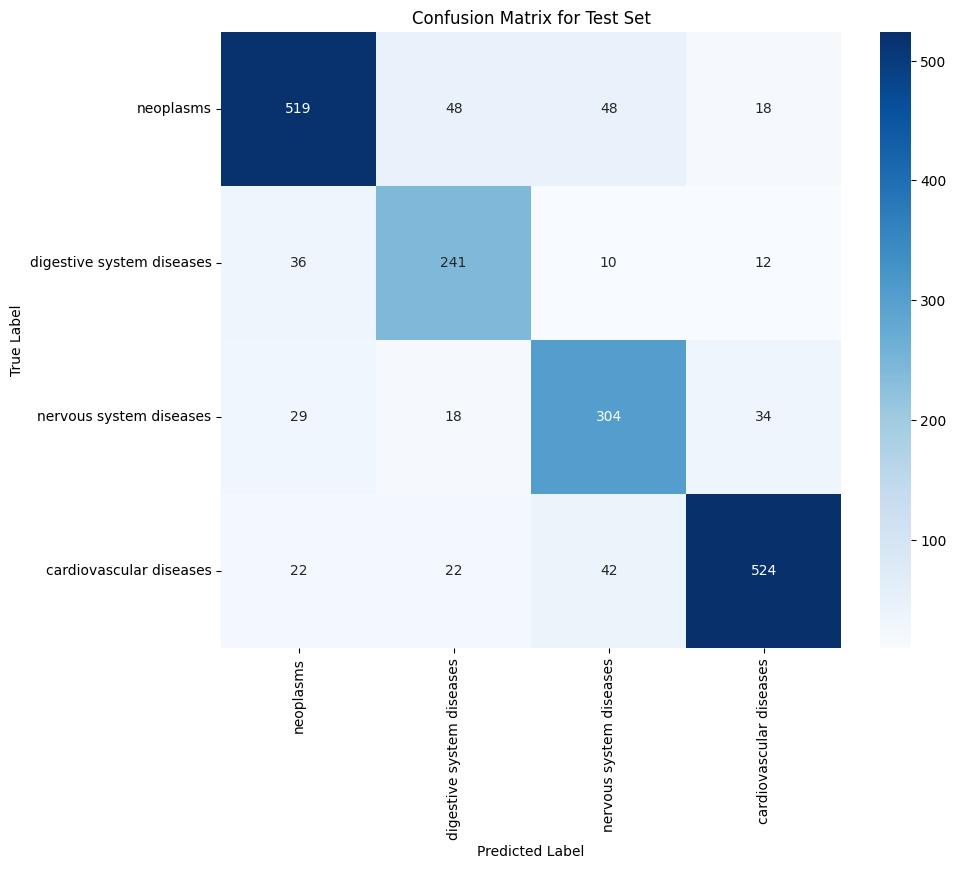

                           precision    recall  f1-score   support

                neoplasms       0.86      0.82      0.84       633
digestive system diseases       0.73      0.81      0.77       299
  nervous system diseases       0.75      0.79      0.77       385
  cardiovascular diseases       0.89      0.86      0.87       610

                 accuracy                           0.82      1927
                macro avg       0.81      0.82      0.81      1927
             weighted avg       0.83      0.82      0.83      1927



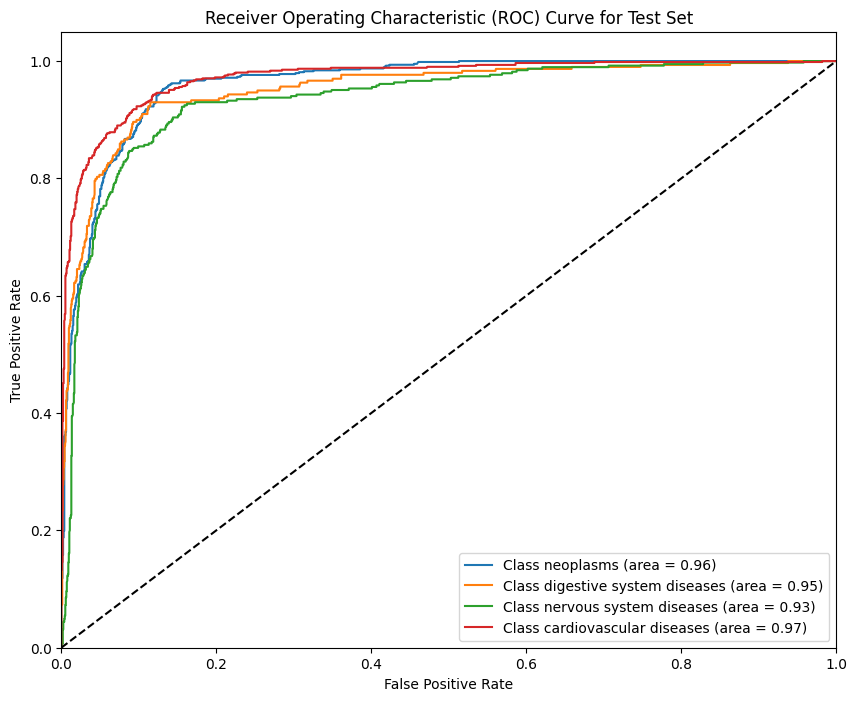

Length of train_loss_values: 6
Length of val_loss_values: 7
Length of train_acc_values: 0
Length of val_acc_values: 7


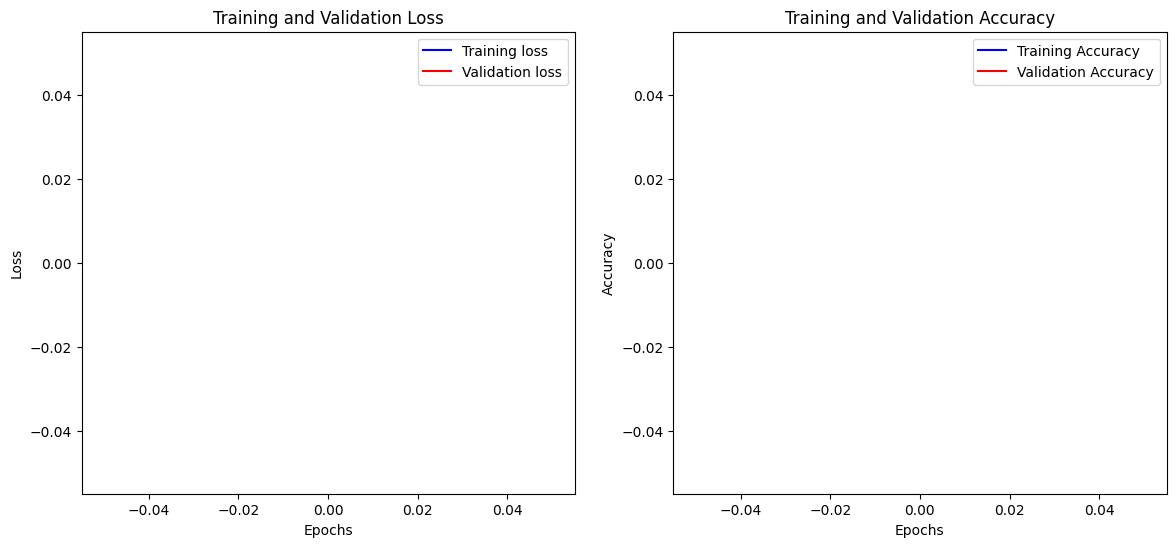

In [4]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

# Disable Weights & Biases logging
os.environ["WANDB_DISABLED"] = "true"

# Load the data
train_data = pd.read_csv('/kaggle/input/med-con/medical_tc_train.csv')
test_data = pd.read_csv('/kaggle/input/med-con/medical_tc_test.csv')

# Define the condition labels and their names
label_dict = {
    1: "neoplasms",
    2: "digestive system diseases",
    3: "nervous system diseases",
    4: "cardiovascular diseases",
    5: "general pathological conditions"
}

# Remove the "general pathological conditions" class (label 5)
train_data = train_data[train_data['condition_label'] != 5]
test_data = test_data[test_data['condition_label'] != 5]

# Update the label dictionary to exclude "general pathological conditions"
label_dict = {
    1: "neoplasms",
    2: "digestive system diseases",
    3: "nervous system diseases",
    4: "cardiovascular diseases"
}

# Encode the labels (subtract 1 to make them zero-indexed)
train_data['condition_label'] = train_data['condition_label'].astype(int) - 1
test_data['condition_label'] = test_data['condition_label'].astype(int) - 1

# Determine the target size for balancing
target_size = train_data['condition_label'].value_counts().max()

# Separate each class into a different dataframe
dfs = [train_data[train_data.condition_label == i] for i in range(len(label_dict))]

# Upsample minority classes to the target size
dfs_balanced = [resample(df, replace=True, n_samples=int(target_size), random_state=123) if len(df) < target_size else df for df in dfs]

# Combine all the balanced dataframes
train_data_balanced = pd.concat(dfs_balanced)

# Print the class distribution after balancing
print("Class distribution after balancing:")
print(train_data_balanced['condition_label'].value_counts())

# Rename 'condition_label' to 'labels' for consistency with Hugging Face datasets
train_data_balanced.rename(columns={'condition_label': 'labels'}, inplace=True)
test_data.rename(columns={'condition_label': 'labels'}, inplace=True)

# Split the training data into training and validation sets
train_data, val_data = train_test_split(train_data_balanced, test_size=0.2, stratify=train_data_balanced['labels'], random_state=42)

# Convert the data to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

# Load the BERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_dict))

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['medical_abstract'], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=8,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.1,
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False
)

# Define compute metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': (preds == p.label_ids).mean()
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train the model
train_result = trainer.train()
metrics = train_result.metrics
trainer.save_model()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Evaluation results on validation set: {eval_results}")

# Evaluate the model on the test set
test_results = trainer.predict(test_dataset)
test_preds = np.argmax(test_results.predictions, axis=1)
test_labels = test_results.label_ids

# Calculate precision, recall, f1-score for test set
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Confusion matrix for test set
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_dict.values(), yticklabels=label_dict.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Classification report for test set
test_report = classification_report(test_labels, test_preds, target_names=label_dict.values())
print(test_report)

# ROC Curve and AUROC for test set
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_dict)):
    fpr[i], tpr[i], _ = roc_curve(test_labels, test_results.predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(label_dict)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_dict[i+1]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
plt.show()

# Extract losses and accuracy values
training_logs = trainer.state.log_history

train_loss_values = [log['loss'] for log in training_logs if 'loss' in log]
val_loss_values = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]
train_acc_values = [log['accuracy'] for log in training_logs if 'accuracy' in log]
val_acc_values = [log['eval_accuracy'] for log in training_logs if 'eval_accuracy' in log]

# Print lengths of the lists for debugging
print(f"Length of train_loss_values: {len(train_loss_values)}")
print(f"Length of val_loss_values: {len(val_loss_values)}")
print(f"Length of train_acc_values: {len(train_acc_values)}")
print(f"Length of val_acc_values: {len(val_acc_values)}")

# Ensure equal length for plotting
min_len = min(len(train_loss_values), len(val_loss_values), len(train_acc_values), len(val_acc_values))
train_loss_values = train_loss_values[:min_len]
val_loss_values = val_loss_values[:min_len]
train_acc_values = train_acc_values[:min_len]
val_acc_values = val_acc_values[:min_len]
epochs = range(1, min_len + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


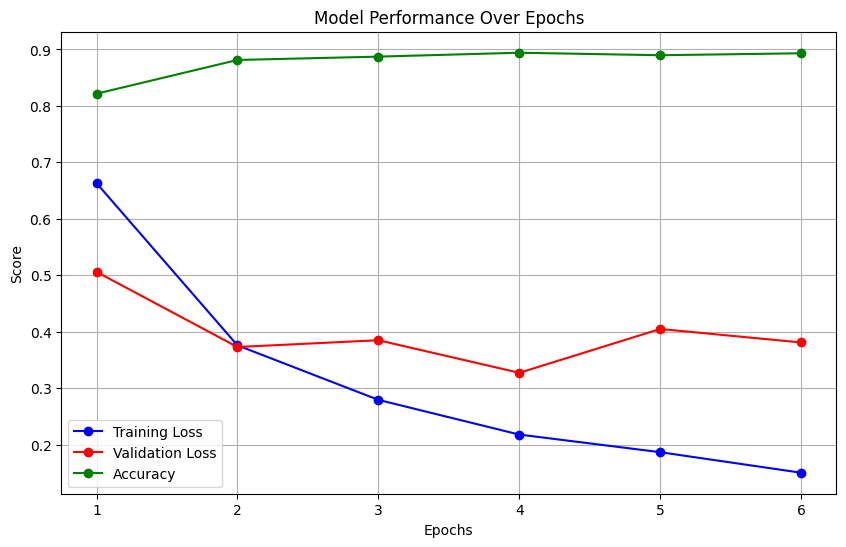

In [5]:
import matplotlib.pyplot as plt

# Data from training logs
epochs = [1, 2, 3, 4, 5, 6]
training_loss = [0.663200, 0.375800, 0.279200, 0.217700, 0.186500, 0.150100]
validation_loss = [0.505973, 0.372827, 0.384877, 0.327135, 0.404756, 0.380905]
precision = [0.832411, 0.883233, 0.889904, 0.895287, 0.891621, 0.894281]
recall = [0.821640, 0.881423, 0.887352, 0.894269, 0.889822, 0.893281]
f1_score = [0.819683, 0.881033, 0.887706, 0.894219, 0.889408, 0.893187]
accuracy = [0.821640, 0.881423, 0.887352, 0.894269, 0.889822, 0.893281]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'b-o', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-o', label='Validation Loss')
plt.plot(epochs, accuracy, 'g-o', label='Accuracy')

# Titles and labels
plt.title('Model Performance Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

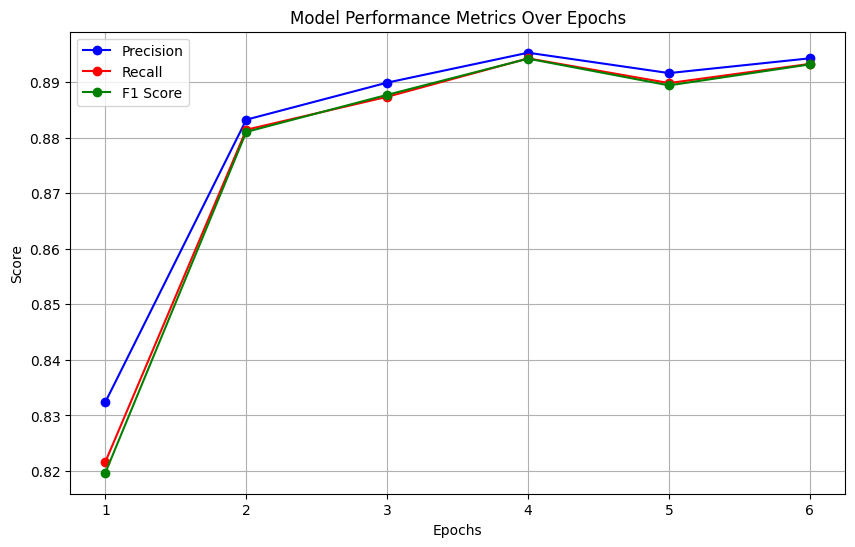

In [7]:
import matplotlib.pyplot as plt

# Data from training logs
epochs = [1, 2, 3, 4, 5, 6]
training_loss = [0.663200, 0.375800, 0.279200, 0.217700, 0.186500, 0.150100]
validation_loss = [0.505973, 0.372827, 0.384877, 0.327135, 0.404756, 0.380905]
precision = [0.832411, 0.883233, 0.889904, 0.895287, 0.891621, 0.894281]
recall = [0.821640, 0.881423, 0.887352, 0.894269, 0.889822, 0.893281]
f1 = [0.819683, 0.881033, 0.887706, 0.894219, 0.889408, 0.893187]
accuracy = [0.821640, 0.881423, 0.887352, 0.894269, 0.889822, 0.893281]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, precision, 'b-o', label='Precision')
plt.plot(epochs, recall, 'r-o', label='Recall')
plt.plot(epochs, f1, 'g-o', label='F1 Score')

# Titles and labels
plt.title('Model Performance Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Show plot
plt.show()